## Churn analysis

By default $\alpha$ = 0.05

In [1]:
import pandas as pd
import numpy as np

from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

import itertools

In [2]:
ALPHA = 0.05

In [56]:
df = pd.read_csv('churn_analysis.csv', index_col=0)
df.head()

,state,account_length,area_code,intl_plan,vmail_plan,vmail_message,day_mins,day_calls,day_charge,eve_mins,...,night_mins,night_calls,night_charge,intl_mins,intl_calls,intl_charge,custserv_calls,treatment,mes_estim,churn
0,KS,128,415,no,yes,25,265.1,110,45.07,197.4,...,244.7,91,11.01,10.0,3,2.70,1,1,0.65,False.
1,OH,107,415,no,yes,26,161.6,123,27.47,195.5,...,254.4,103,11.45,13.7,3,3.70,1,0,0.55,False.
2,NJ,137,415,no,no,0,243.4,114,41.38,121.2,...,162.6,104,7.32,12.2,5,3.29,0,0,0.72,False.
3,OH,84,408,yes,no,0,299.4,71,50.90,61.9,...,196.9,89,8.86,6.6,7,1.78,2,1,0.28,False.
4,OK,75,415,yes,no,0,166.7,113,28.34,148.3,...,186.9,121,8.41,10.1,3,2.73,3,2,0.45,False.


### 1

In [4]:
df_treat1 = df[df['treatment']==1]

In [5]:
cnt_states = df_treat1['state'].unique()
cnt_pairs = list(itertools.combinations(cnt_states, 2))

In [7]:
subtable = pd.crosstab(df_treat1['churn'], df_treat1['state'])
subtable

state,AK,AL,AR,AZ,CA,CO,CT,DC,DE,FL,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
churn,,,,,,,,,,,,,,,,,,,,,
False.,19,25,11,17,10,17,25,18,16,18,...,20,11,14,18,20,18,16,22,27,20
True.,1,5,5,2,5,5,5,1,1,2,...,3,1,6,4,3,5,7,2,5,2


In [8]:
print(stats.chi2_contingency(subtable)[1])

0.709759004277847


In [9]:
#correction param uses correction of Yates (поправка Йетса, используется при малом кол-ве наблюдений для таблиц 2x2)
chi2 = []
for k in range(len(cnt_pairs)):
    chi2.append(stats.chi2_contingency(subtable.loc[:, cnt_pairs[k]], correction=False)[1])

In [10]:
print(len([x for x in chi2 if x < ALPHA]))

34


Here correction on multiple testing have to be used! Holm for instance

In [90]:
from statsmodels.sandbox.stats.multicomp import multipletests 
reject, p_vals_corrected, *a = multipletests(chi2, alpha = 0.05, method = 'holm')
len([x for x in p_vals_corrected if x < ALPHA])

0

### 2

In [11]:
print(df_treat1.loc[df_treat1['state']=='KS',['state', 'churn']].shape)
#seems we've got quite small samples but for using chi2 their volumes should be >= 40

(25, 2)


In [12]:
subtable.loc[:, cnt_pairs[k]]

state,HI,SC
churn,,
False.,12,16
True.,1,5


### 3

In [13]:
chi2_corr = []
for k in range(len(cnt_pairs)):
    chi2_corr.append(stats.chi2_contingency(subtable.loc[:, cnt_pairs[k]], correction=True)[1])

In [14]:
print(len([x for x in chi2_corr if x < ALPHA]))

0


### 4

In [15]:
#like chi2 but without apporoximation discrete dist with continious
#it means fisher criterion uses comb. method sorting out all variants
fish = []
for k in range(len(cnt_pairs)):
    fish.append(stats.fisher_exact(subtable.loc[:, cnt_pairs[k]])[1])

In [16]:
print(len([x for x in fish if x < ALPHA]))

10


In [87]:
print(f"Average p_values Fisher criterion: {np.mean(fish)}")
print(f"Average p_values chi2 criterion no correction: {np.mean(chi2)}")
print(f"Average p_values chi2 criterion with Yates correction: {np.mean(chi2_corr)}")

Average p_values Fisher criterion: 0.6483383060020681
Average p_values chi2 criterion no correction: 0.5018273798739158
Average p_values chi2 criterion with Yates correction: 0.6640566382051047


### 5

In [88]:
print(stats.pearsonr(df['day_calls'].values, df['mes_estim'].values))

(-0.051794350587572625, 0.0027798836869756707)


### 6

In [18]:
print(stats.spearmanr(df['day_calls'].values, df['mes_estim'].values))

SpearmanrResult(correlation=0.043349880533927444, pvalue=0.012317367189170541)


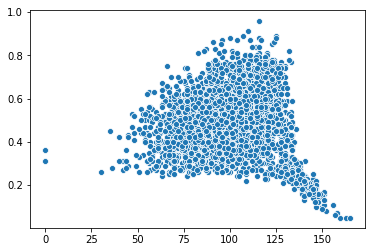

In [19]:
sns.scatterplot(df['day_calls'].values, df['mes_estim'].values)
plt.show()

### 7
without computations

### 8

$$\phi_c(X^{n}_1, X^{n}_2) = \sqrt{\frac{ \chi^2(X^{n}_1, X^{n}_2)}{n(min(K_1, K_2) - 1)}}$$


In [20]:
subtable

state,AK,AL,AR,AZ,CA,CO,CT,DC,DE,FL,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
churn,,,,,,,,,,,,,,,,,,,,,
False.,19,25,11,17,10,17,25,18,16,18,...,20,11,14,18,20,18,16,22,27,20
True.,1,5,5,2,5,5,5,1,1,2,...,3,1,6,4,3,5,7,2,5,2


In [22]:
#computation of cramer's V corr and p_value that cramer's V is = 0
k1 = df_treat1['state'].unique().shape[0]
k2 = df_treat1['churn'].unique().shape[0]

stat_p = stats.chi2_contingency(subtable)[:2]
n = df_treat1.shape[0] #==sum(df_treat.groupby(by=['state'])['churn'].count().values)
v_cram_corr = np.sqrt(stat_p[0]/(n * (min(k1,k2)-1)))
print(v_cram_corr, stat_p[0], stat_p[1])

0.2003932150203332 44.05271236692549 0.709759004277847


stat chi2 is not good in this case due to the data, it's small<=>we dont have enough instances

### 9

treatment #1 is control group and #2 and #0 are exp

In [28]:
from statsmodels.stats.proportion import proportion_confint

In [57]:
df[['churn']] = df['churn'].apply(lambda x: 1 if x == 'True.' else 0)

In [59]:
churn0, churn1, churn2 = df.loc[df['treatment']==0, 'churn'].values, \
    df.loc[df['treatment']==1, 'churn'].values, df.loc[df['treatment']==2, 'churn'].values

start with conf int

In [60]:
p0, p1, p2 = np.mean(churn0), np.mean(churn1), np.mean(churn2)
print(p0, p1, p2)

0.14563106796116504 0.1640838650865998 0.12511332728921123


i like wilson's conf int but in this case it seems that it doesn't matter wilson or normal since probabilities is quite big

In [45]:
print(f"CI Wilson fot strategy #0 {proportion_confint(sum(churn0), len(churn0), method = 'wilson')}")
print(f"CI Wilson fot strategy #1 {proportion_confint(sum(churn1), len(churn1), method = 'wilson')}")
print(f"CI Wilson fot strategy #2 {proportion_confint(sum(churn2), len(churn2), method = 'wilson')}")

CI Wilson fot strategy #0 (0.1262891297794312, 0.16736787598019826)
CI Wilson fot strategy #1 (0.14334706983717693, 0.18716506331819044)
CI Wilson fot strategy #2 (0.1068800961786988, 0.14594875893019524)


CI for #1 cross with #0 and cross with #2. Try diference

In [62]:
#since sample are independent
def proportions_confint_diff_ind(sample1, sample2, alpha = ALPHA):    
    z = stats.norm.ppf(1 - alpha / 2.)   
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [67]:
print(f"confidence interval for #1 and #0: {proportions_confint_diff_ind(churn1, churn0)}")
print(f"confidence interval for #1 and #2: {proportions_confint_diff_ind(churn1, churn2)}")
print(f"confidence interval for #0 and #2: {proportions_confint_diff_ind(churn0, churn2)}")

confidence interval for #1 and #0: (-0.011583241590025106, 0.04848883584089464)
confidence interval for #1 and #2: (0.00961876673809212, 0.06832230885668503)
confidence interval for #0 and #2: (-0.007820886720395197, 0.04885636806430281)


Since CI for #0 and #1 contains zero we cant conclude that #0 strategy is good or bad and vice versa with #2 and #1 CI is to the right from zero, it means that #1 is better than #2


Let's use t-test to compare p0, p1, p2 knowing that sample are indep. Also it seems more correct since we can make correction since use test 2! hypotheses so we've to compare p_val with ALPHA/2 for example (Bonferroni correction)

In [77]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - stats.norm.cdf(z_stat)
    
def proportions_diff_z_stat_ind(n1=None, n2=None, cnt_pos1=None, cnt_pos2=None,
                                p1=None, p2=None, sample1=None, sample2=None):
    if sample1 is not None:
        n1 = len(sample1)
        cnt_pos1 = sum(sample1)
        #подсчет вероятноти для 1-й популяции
        p1 = cnt_pos1 / n1
    elif n1 is not None and cnt_pos1 is not None:
        p1 = cnt_pos1 / n1
    else:
        assert(n1 is not None) , 'You give no sample, no cnt_pos1, so it must be p1 and n1'
        
    if sample2 is not None:
        n2 = len(sample2)
        cnt_pos2 = sum(sample2)
        #подсчет вероятноти для 2-й популяции
        p2 = cnt_pos2 / n2
    elif n2 is not None and cnt_pos2 is not None:
        p2 = cnt_pos2 / n2
    else:
        assert(n1 is not None) , 'You give no sample, no cnt_pos1, so it must be p1 and n1'
        
    P = (p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [78]:
stat01 = proportions_diff_z_stat_ind(sample1=churn0, sample2=churn1)
stat21 = proportions_diff_z_stat_ind(sample1=churn2, sample2=churn1)

In [80]:
proportions_diff_z_test(stat01), proportions_diff_z_test(stat21) 

(0.2283311639045107, 0.009348084294451109)

With ALPHA/2 = 0.25 we can coduct that #2 is statistically significant, but not the same with #0

compare #0 and #2

In [85]:
stat02 = proportions_diff_z_stat_ind(sample1=churn0, sample2=churn2)
proportions_diff_z_test(stat02)

0.1564246886050802

In [ ]:
+